In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Read a CSV file into a DataFrame
csv_file_path = '../XRPUSDT_Dataset/XRP_dataset.csv'  # Replace with your CSV file path
df = pd.read_csv(csv_file_path)

# Display the first few rows of the DataFrame
print(df.head())

   Unnamed: 0      open_time     open     high      low    close    volume  \
0           0  1567296300000  0.25808  0.25821  0.25778  0.25787   66709.6   
1           1  1567296600000  0.25787  0.25789  0.25744  0.25751   76896.3   
2           2  1567296900000  0.25751  0.25793  0.25745  0.25774   71280.3   
3           3  1567297200000  0.25778  0.25788  0.25757  0.25781   45598.6   
4           4  1567297500000  0.25781  0.25804  0.25753  0.25804  114789.9   

      close_time  
0  1567296599999  
1  1567296899999  
2  1567297199999  
3  1567297499999  
4  1567297799999  


In [3]:
df = df.drop(columns=['Unnamed: 0'])
df = df[0:500]
print(df.head())

       open_time     open     high      low    close    volume     close_time
0  1567296300000  0.25808  0.25821  0.25778  0.25787   66709.6  1567296599999
1  1567296600000  0.25787  0.25789  0.25744  0.25751   76896.3  1567296899999
2  1567296900000  0.25751  0.25793  0.25745  0.25774   71280.3  1567297199999
3  1567297200000  0.25778  0.25788  0.25757  0.25781   45598.6  1567297499999
4  1567297500000  0.25781  0.25804  0.25753  0.25804  114789.9  1567297799999


In [4]:
def getATR(df, period):
    
    # Calculate the True Range (TR)
    df['high_low'] = df['high'] - df['low']
    df['high_close'] = abs(df['high'] - df['close'].shift())
    df['low_close'] = abs(df['low'] - df['close'].shift())
    df['tr'] = df[['high_low', 'high_close', 'low_close']].max(axis=1)

    # Calculate the Average True Range (ATR)
    df['atr'] = df['tr'].rolling(window=period).mean()

    return df

In [5]:
def getADX(df, period):
    high = df['high']
    low  = df['low']

    plus_dm = high.diff()
    plus_dm[plus_dm < 0] = 0
    minus_dm = low.diff()
    minus_dm[minus_dm > 0] = 0

    atr = getATR(df, period)

    plus_di = 100 * (plus_dm.ewm(alpha = 1/period).mean()/atr['atr'])
    minus_di = abs(100 * (minus_dm.ewm(alpha = 1/period).mean() / atr['atr']))
    dx = (abs(plus_di - minus_di) / (plus_di + minus_di)) * 100
    adx = ((dx.shift(1) * (period - 1)) + dx) / period
    adx = adx.ewm(alpha=1/period).mean()
    return plus_di, minus_di, adx


In [6]:
df['plus_di'] = pd.DataFrame(getADX(df, 6)[0]).rename(columns = {0:'plus_di'})
df['minus_di'] = pd.DataFrame(getADX(df, 6)[1]).rename(columns = {0:'minus_di'})
df['adx'] = pd.DataFrame(getADX(df, 6)[2]).rename(columns = {0:'adx'})
df.head()

,open_time,open,high,low,close,volume,close_time,high_low,high_close,low_close,tr,atr,plus_di,minus_di,adx
0,1567296300000,0.25808,0.25821,0.25778,0.25787,66709.6,1567296599999,0.00043,NaN,NaN,0.00043,NaN,NaN,NaN,NaN
1,1567296600000,0.25787,0.25789,0.25744,0.25751,76896.3,1567296899999,0.00045,0.00002,0.00043,0.00045,NaN,NaN,NaN,NaN
2,1567296900000,0.25751,0.25793,0.25745,0.25774,71280.3,1567297199999,0.00048,0.00042,0.00006,0.00048,NaN,NaN,NaN,NaN
3,1567297200000,0.25778,0.25788,0.25757,0.25781,45598.6,1567297499999,0.00031,0.00014,0.00017,0.00031,NaN,NaN,NaN,NaN
4,1567297500000,0.25781,0.25804,0.25753,0.25804,114789.9,1567297799999,0.00051,0.00023,0.00028,0.00051,NaN,NaN,NaN,NaN


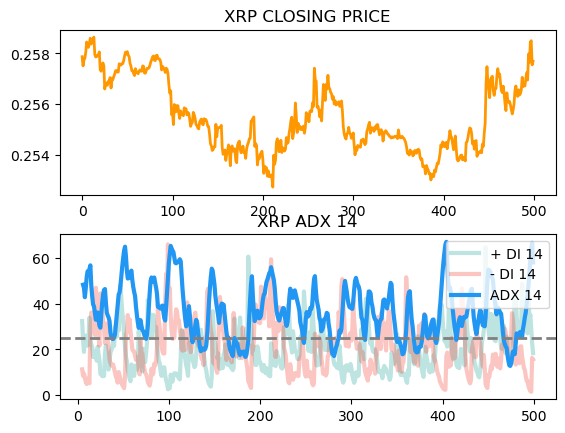

In [7]:
ax1 = plt.subplot2grid((11,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((11,1), (6,0), rowspan = 5, colspan = 1)
ax1.plot(df['close'], linewidth = 2, color = '#ff9800')
ax1.set_title('XRP CLOSING PRICE')
ax2.plot(df['plus_di'], color = '#26a69a', label = '+ DI 14', linewidth = 3, alpha = 0.3)
ax2.plot(df['minus_di'], color = '#f44336', label = '- DI 14', linewidth = 3, alpha = 0.3)
ax2.plot(df['adx'], color = '#2196f3', label = 'ADX 14', linewidth = 3)
ax2.axhline(25, color = 'grey', linewidth = 2, linestyle = '--')
ax2.legend()
ax2.set_title('XRP ADX 14')
plt.show()

In [8]:
def implement_adx_strategy(prices, pdi, ndi, adx):
    buy_price = []
    sell_price = []
    adx_signal = []
    signal = 0
    
    for i in range(len(prices)-1):
        i += 1
        if adx[i-1] < 25 and adx[i] > 25 and pdi[i] > ndi[i]:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                adx_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                adx_signal.append(0)
        elif adx[i-1] < 25 and adx[i] > 25 and ndi[i] > pdi[i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                adx_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                adx_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            adx_signal.append(0)
            
    return buy_price, sell_price, adx_signal

In [9]:
buy_price, sell_price, adx_signal = implement_adx_strategy(df['close'], df['plus_di'], df['minus_di'], df['adx'])
df = df[1:]

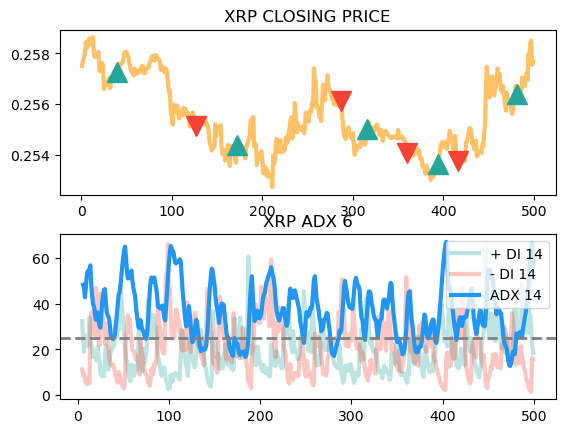

In [10]:
ax1 = plt.subplot2grid((11,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((11,1), (6,0), rowspan = 5, colspan = 1)
ax1.plot(df['close'], linewidth = 3, color = '#ff9800', alpha = 0.6)
ax1.set_title('XRP CLOSING PRICE')
ax1.plot(df.index, buy_price, marker = '^', color = '#26a69a', markersize = 14, linewidth = 0, label = 'BUY SIGNAL')
ax1.plot(df.index, sell_price, marker = 'v', color = '#f44336', markersize = 14, linewidth = 0, label = 'SELL SIGNAL')
ax2.plot(df['plus_di'], color = '#26a69a', label = '+ DI 14', linewidth = 3, alpha = 0.3)
ax2.plot(df['minus_di'], color = '#f44336', label = '- DI 14', linewidth = 3, alpha = 0.3)
ax2.plot(df['adx'], color = '#2196f3', label = 'ADX 14', linewidth = 3)
ax2.axhline(25, color = 'grey', linewidth = 2, linestyle = '--')
ax2.legend()
ax2.set_title('XRP ADX 6')
plt.show()

In [11]:
#strategy
position = []
for i in range(len(adx_signal)):
    if adx_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(df['close'])):
    if adx_signal[i] == 1:
        position[i] = 1
    elif adx_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
close_price = df['close']
plus_di = df['plus_di']
minus_di = df['minus_di']
adx = df['adx']
adx_signal = pd.DataFrame(adx_signal).rename(columns = {0:'adx_signal'}).set_index(df.index)
position = pd.DataFrame(position).rename(columns = {0:'adx_position'}).set_index(df.index)

frames = [close_price, plus_di, minus_di, adx, adx_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)

strategy

,close,plus_di,minus_di,adx,adx_signal,adx_position
1,0.25751,NaN,NaN,NaN,0,1
2,0.25774,NaN,NaN,NaN,0,1
3,0.25781,NaN,NaN,NaN,0,1
4,0.25804,NaN,NaN,NaN,0,1
5,0.25845,32.434916,11.296731,NaN,0,1
...,...,...,...,...,...,...
495,0.25764,31.901944,2.687451,54.055575,0,1
496,0.25845,35.214665,1.789524,59.286096,0,1
497,0.25850,28.981578,1.472774,64.459745,0,1
498,0.25755,22.674815,16.290562,66.717131,0,1


In [17]:
xrp_ret

,returns
0,0.00023
1,0.00007
2,0.00023
3,0.00041
4,-0.00010
...,...
493,-0.00034
494,0.00081
495,0.00005
496,-0.00095


In [25]:
#backtesting
import math

xrp_ret = pd.DataFrame(np.diff(df['close'])).rename(columns = {0:'returns'})
adx_strategy_ret = []

for i in range(1, len(xrp_ret)):
    adx_strategy_ret.append(xrp_ret['returns'][i] * strategy['adx_position'][i])

adx_strategy_ret_df = pd.DataFrame(adx_strategy_ret).rename(columns = {0:'adx_returns'})
investment_value = 1000
adx_investment_ret = []

for i in range(1, len(adx_strategy_ret_df['adx_returns'])):
    number_of_stocks = math.floor(investment_value/df['close'][i])
    returns = number_of_stocks*adx_strategy_ret_df['adx_returns'][i]
    adx_investment_ret.append(returns)

adx_investment_ret_df = pd.DataFrame(adx_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(adx_investment_ret_df['investment_returns']), 2)
profit_percentage = math.floor((total_investment_ret/investment_value)*100)
print('Profit gained from the ADX strategy by investing P1000 in XRP : ' + str(total_investment_ret))
print('Profit percentage of the ADX strategy : ' + str(profit_percentage))


Profit gained from the ADX strategy by investing P1000 in XRP : -4.76
Profit percentage of the ADX strategy : -1
